In [1]:
import os
from collections import Counter

from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, date2num

METADATA_DIR = "Metadata"
SEQUENCES_DIR = "Sequences"
REFSEQ_DIR = "RefSeq"
PLOTS_DIR = "Output"

REFERENCE = 'EPI_ISL_402125'

NUCLEOTIDE_AMBIGUITY = ('Y', 'R', 'W', 'S', 'K', 'M', 'V', 'D', 'B', 'H', 'N', '-', 'I')

In [29]:
plt.rcParams.update({'font.size': 22, 'font.weight': 'bold'})

In [2]:
metadata = pd.read_csv(os.path.join(METADATA_DIR, "SARS_CoV_2.csv"), index_col=0)
metadata['date'] = pd.to_datetime(metadata['date'], errors="coerce")

In [3]:
siteMapping = pd.read_csv(os.path.join(REFSEQ_DIR, "SARS_CoV_2.csv"), index_col=0)

# Mutation on amino acid level

In [4]:
nucleotide = SeqIO.index(os.path.join(SEQUENCES_DIR, "nucleotide.fasta"), "fasta")
nucleotideRef = nucleotide[REFERENCE]

In [5]:
polypeptide = SeqIO.index(os.path.join(SEQUENCES_DIR, "polypeptide.fasta"), "fasta")
polypeptideRef = polypeptide[REFERENCE]

In [6]:
df = []

for record in nucleotide.values():
    snpNum = sum(0 if base in NUCLEOTIDE_AMBIGUITY or ref == base else 1
                   for ref, base in zip(nucleotideRef, record))
    accession = record.id
    mutNum = sum(0 if base in ('X', '-') or ref == base else 1
                   for ref, base in zip(polypeptideRef, polypeptide[accession]))
    if record.id in metadata.index:
        df.append({
            "accession": accession,
            "clade": metadata.loc[accession, 'Nextstrain_clade'],
            "date": metadata.loc[accession, 'date'],
            "mutNum": mutNum,
            "snpNum": snpNum
        })

df = pd.DataFrame.from_dict(df)
df.loc[pd.isna(df['clade']), 'clade'] = "unknown"

In [7]:
badSeqs = df[df['snpNum'] >= 20000]['accession']

badSeqsRatio = []

for month, monthInfo in df.groupby(df['date'].dt.to_period("M")):
    badSeed = monthInfo['accession'].isin(badSeqs)
    clade = ",".join(set(monthInfo.loc[badSeed, "clade"]))
    badRatio = sum(badSeed) / len(monthInfo)
    if badRatio:
        badSeqsRatio.append({
            "month": month,
            "proportion": badRatio,
            "clades": clade
        })

badSeqsRatio = pd.DataFrame.from_dict(badSeqsRatio)
badSeqsRatio.set_index('month').to_csv(os.path.join(PLOTS_DIR, "proportion.tsv"), sep='\t')

In [8]:
colors = {
    "Other clades": "lightblue",
    "501Y V1": "red",
    "501Y V2": "yellow",
    "501Y V3": "green"
}

In [9]:
def polyfit_with_fixed_points(n, x, y, xf, yf) :
    mat = np.empty((n + 1 + len(xf),) * 2)
    vec = np.empty((n + 1 + len(xf),))
    x_n = x**np.arange(2 * n + 1)[:, None]
    yx_n = np.sum(x_n[:n + 1] * y, axis=1)
    x_n = np.sum(x_n, axis=1)
    idx = np.arange(n + 1) + np.arange(n + 1)[:, None]
    mat[:n + 1, :n + 1] = np.take(x_n, idx)
    xf_n = xf**np.arange(n + 1)[:, None]
    mat[:n + 1, n + 1:] = xf_n / 2
    mat[n + 1:, :n + 1] = xf_n.T
    mat[n + 1:, n + 1:] = 0
    vec[:n + 1] = yx_n
    vec[n + 1:] = yf
    params = np.linalg.solve(mat, vec)
    return params[:n + 1]

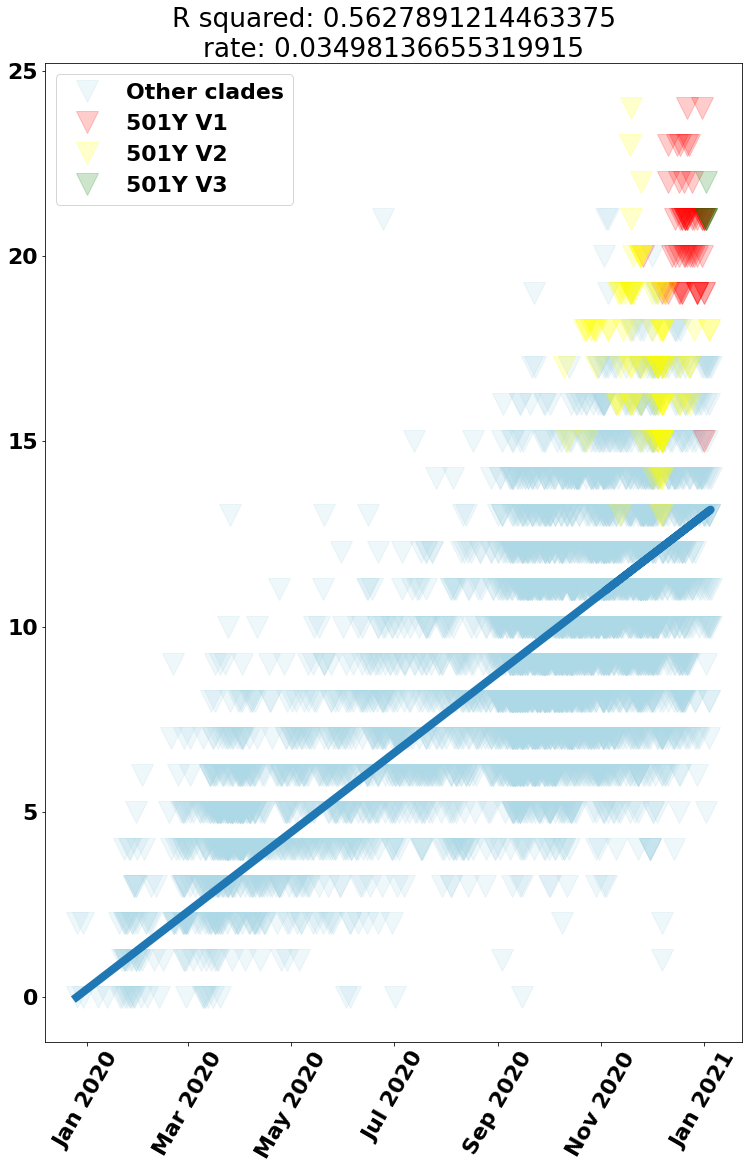

In [36]:
noOutlier = df[df['snpNum'] < 20000]

isV1 = noOutlier['clade'].str.contains("501Y.V1")
isV2 = noOutlier['clade'].str.contains("501Y.V2")
isV3 = noOutlier['clade'].str.contains("501Y.V3")

N501Y_V1 = noOutlier[isV1]
N501Y_V2 = noOutlier[isV2]
N501Y_V3 = noOutlier[isV3]

nonN501Y = noOutlier[~(isV1 | isV2 | isV3)]

fig, ax = plt.subplots(figsize = (12.5, 18))

clade = "Other clades"
ax.plot_date(
    nonN501Y['date'],
    nonN501Y['mutNum'],
    alpha = 0.2,
    marker = 'v',
    color = colors[clade],
    label = clade,
    markersize = 22
)
clade = "501Y V1"
ax.plot_date(
    N501Y_V1['date'],
    N501Y_V1['mutNum'],
    alpha = 0.2,
    marker = 'v',
    color = colors[clade],
    label = clade,
    markersize = 22
)
clade = "501Y V2"
ax.plot_date(
    N501Y_V2['date'],
    N501Y_V2['mutNum'],
    alpha = 0.2,
    marker = 'v',
    color = colors[clade],
    label = clade,
    markersize = 22
)
clade = "501Y V3"
ax.plot_date(
    N501Y_V3['date'],
    N501Y_V3['mutNum'],
    alpha = 0.2,
    marker = 'v',
    color = colors[clade],
    label = clade,
    markersize = 22
)

ax.tick_params(axis='x', labelrotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

dateAsNum = date2num(noOutlier["date"])
# m, b = np.polyfit(dateAsNum, noOutlier['mutNum'], 1)

b, m = polyfit_with_fixed_points(1, 
                                 np.array(dateAsNum),
                                 np.array(noOutlier['mutNum']),
                                 np.array([dateAsNum[0]]),
                                 np.array([0]))
# poly = np.polynomial.Polynomial(params)
# plt.plot(noOutlier["date"], poly(dateAsNum), '-')

plt.plot(noOutlier["date"], m*dateAsNum + b, linewidth = 8)

ssTotal = np.square(np.array(noOutlier['mutNum']) - np.mean(np.array(noOutlier['mutNum'])))
ssReg = np.square(np.array(m*dateAsNum + b) - np.mean(np.array(noOutlier['mutNum'])))

plt.title('R squared: {}\nrate: {}'.format(sum(ssReg) / sum(ssTotal), m))

plt.legend(loc='upper left')
plt.savefig(os.path.join(PLOTS_DIR, "mutation_count.pdf"))

plt.show()

## Mutations on Spike protein

The same plot for the Spike protein

In [13]:
spikeSites = siteMapping[siteMapping['product'] == "S"]
spikeAAsites = spikeSites['peptidePos'].unique()
spikeGenomeSites = spikeSites['genomePos'].unique()

In [14]:
spike_start = min(spikeGenomeSites) - 1
spike_end = max(spikeGenomeSites)

spikeAA_start = min(spikeAAsites) - 1
spikeAA_end = max(spikeAAsites)

In [15]:
spikeMut = []

for record in nucleotide.values():
    snpNum = sum(0 if base in NUCLEOTIDE_AMBIGUITY or ref == base else 1
                   for ref, base in zip(nucleotideRef[spike_start:spike_end],
                                        record[spike_start:spike_end]))
    accession = record.id
    mutNum = sum(0 if base in ('X', '-') or ref == base else 1
                   for ref, base in zip(polypeptideRef[spikeAA_start:spikeAA_end],
                                        polypeptide[accession][spikeAA_start:spikeAA_end]))
    if record.id in metadata.index:
        spikeMut.append({
            "accession": accession,
            "clade": metadata.loc[accession, 'Nextstrain_clade'],
            "date": metadata.loc[accession, 'date'],
            "mutNum": mutNum,
            "snpNum": snpNum
        })

spikeMut = pd.DataFrame.from_dict(spikeMut)
spikeMut.loc[pd.isna(spikeMut['clade']), 'clade'] = "unknown"

In [16]:
badSeqs = spikeMut[spikeMut['snpNum'] >= 1000]['accession']

badSeqsRatio = []

for month, monthInfo in spikeMut.groupby(spikeMut['date'].dt.to_period("M")):
    badSeed = monthInfo['accession'].isin(badSeqs)
    clade = ",".join(set(monthInfo.loc[badSeed, "clade"]))
    badRatio = sum(badSeed) / len(monthInfo)
    if badRatio:
        badSeqsRatio.append({
            "month": month,
            "proportion": badRatio,
            "clades": clade
        })

badSeqsRatio = pd.DataFrame.from_dict(badSeqsRatio)
badSeqsRatio.set_index('month').to_csv(os.path.join(PLOTS_DIR, "spike_proportion.tsv"), sep='\t')

In [17]:
noOutlier[noOutlier['clade'].str.contains("501Y.V3")]

,accession,clade,date,mutNum,snpNum
2948,EPI_ISL_792681,20J/501Y.V3,2021-01-02,22,35
2949,EPI_ISL_792683,20J/501Y.V3,2021-01-02,21,33
2950,EPI_ISL_792682,20J/501Y.V3,2021-01-02,21,33
2951,EPI_ISL_792680,20J/501Y.V3,2021-01-02,21,33


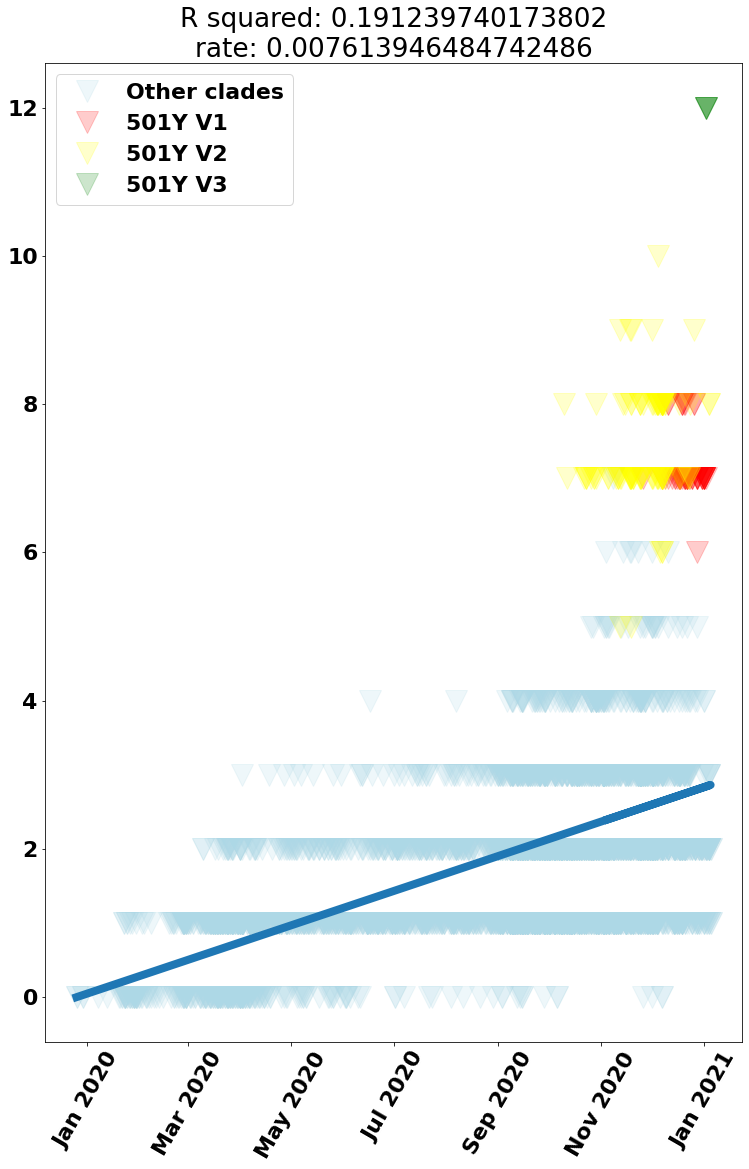

In [38]:
noOutlier = spikeMut[spikeMut['snpNum'] < 1000]

isV1 = noOutlier['clade'].str.contains("501Y.V1")
isV2 = noOutlier['clade'].str.contains("501Y.V2")
isV3 = noOutlier['clade'].str.contains("501Y.V3")

N501Y_V1 = noOutlier[isV1]
N501Y_V2 = noOutlier[isV2]
N501Y_V3 = noOutlier[isV3]

nonN501Y = noOutlier[~(isV1 | isV2 | isV3)]

fig, ax = plt.subplots(figsize = (12.5, 18))

clade = "Other clades"
ax.plot_date(
    nonN501Y['date'],
    nonN501Y['mutNum'],
    alpha = 0.2,
    marker = 'v',
    color = colors[clade],
    label = clade,
    markersize = 22
)
clade = "501Y V1"
ax.plot_date(
    N501Y_V1['date'],
    N501Y_V1['mutNum'],
    alpha = 0.2,
    marker = 'v',
    color = colors[clade],
    label = clade,
    markersize = 22
)
clade = "501Y V2"
ax.plot_date(
    N501Y_V2['date'],
    N501Y_V2['mutNum'],
    alpha = 0.2,
    marker = 'v',
    color = colors[clade],
    label = clade,
    markersize = 22
)
clade = "501Y V3"
ax.plot_date(
    N501Y_V3['date'],
    N501Y_V3['mutNum'],
    alpha = 0.2,
    marker = 'v',
    color = colors[clade],
    label = clade,
    markersize = 22
)

ax.tick_params(axis='x', labelrotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

dateAsNum = date2num(noOutlier["date"])
# m, b = np.polyfit(dateAsNum, noOutlier['mutNum'], 1)

b, m = polyfit_with_fixed_points(1, 
                                 np.array(dateAsNum),
                                 np.array(noOutlier['mutNum']),
                                 np.array([dateAsNum[0]]),
                                 np.array([0]))
# poly = np.polynomial.Polynomial(params)
# plt.plot(noOutlier["date"], poly(dateAsNum), '-')

plt.plot(noOutlier["date"], m*dateAsNum + b, linewidth = 8)

ssTotal = np.square(np.array(noOutlier['mutNum']) - np.mean(np.array(noOutlier['mutNum'])))
ssReg = np.square(np.array(m*dateAsNum + b) - np.mean(np.array(noOutlier['mutNum'])))

plt.title('R squared: {}\nrate: {}'.format(sum(ssReg) / sum(ssTotal), m))

plt.legend(loc='upper left')
plt.savefig(os.path.join(PLOTS_DIR, "spike_mutation_count.pdf"))

plt.show()

In [19]:
noOutlier[noOutlier['mutNum'] >= 12]

,accession,clade,date,mutNum,snpNum
2948,EPI_ISL_792681,20J/501Y.V3,2021-01-02,12,12
2949,EPI_ISL_792683,20J/501Y.V3,2021-01-02,12,12
2950,EPI_ISL_792682,20J/501Y.V3,2021-01-02,12,12
2951,EPI_ISL_792680,20J/501Y.V3,2021-01-02,12,12
